# APS360 Final Project: Covid Mask Detector

### Names: Edwin Zhang, Lance Canlas, Stefano Katsoras, Marie Joy Cuevas

This file contains everything related to training our neural network(s).

## Global Imports

In [1]:
#Imports
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
import os
import random


In [2]:
#Seed constant
SEED_CONST = 2020
#Set seeds to ensure repeatable training
def seed_torch(seed=SEED_CONST):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    print("Set all seeds to {}".format(seed))

#initializes worker function for dataloaders
def _init_fn(worker_id):
    np.random.seed(SEED_CONST + worker_id)

## Loading Our Data

Split the data set into 60% train, 20% valdation, 20% test. Image pre-processing code is in image-preprocessing.ipynb file


In [3]:
#Master dataset
master = torchvision.datasets.ImageFolder('data_color_shifted', transform = transforms.ToTensor())

#split indexes
train_size = int(0.6 * len(master))
val_size = int(0.2 *len(master))
test_size = len(master) - val_size - train_size

train_set, val_set, test_set = torch.utils.data.random_split(master, [train_size, val_size, test_size])
print ("Length of training set: {}".format(len(train_set)))
print ("Length of val set: {}".format(len(val_set)))
print ("Length of test set: {}".format(len(test_set)))

Length of training set: 3485
Length of val set: 1161
Length of test set: 1163


In [4]:
def display_data (data_loader):
    '''
    Displays a few images to see if our data loaded properly
    
    data_loader: torch data_loader
    data_type: a string to show which data is displayed
    '''

    classes = ['Incorrect Mask', 'Mask', 'No Mask'] #CHANGED

    data = iter(data_loader)
    image, label = data.next()
    npImages = image.numpy() 
    
    # plot the images with labels
    fig = plt.figure(figsize=(25, 4))
    for i in np.arange(20):
        ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(npImages[i], (1, 2, 0)))
        ax.set_title(classes[label[i]])

#### Check Our Training Data

<ipython-input-4-5946c92dc02c>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])


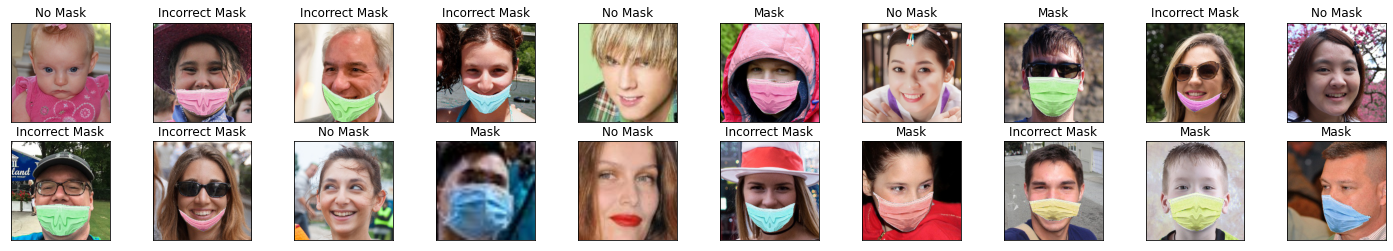

In [5]:
train_data = torch.utils.data.DataLoader(train_set, batch_size=32, num_workers=1, shuffle=True)
display_data(train_data)

#### Check Our Validation Data

<ipython-input-4-5946c92dc02c>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])


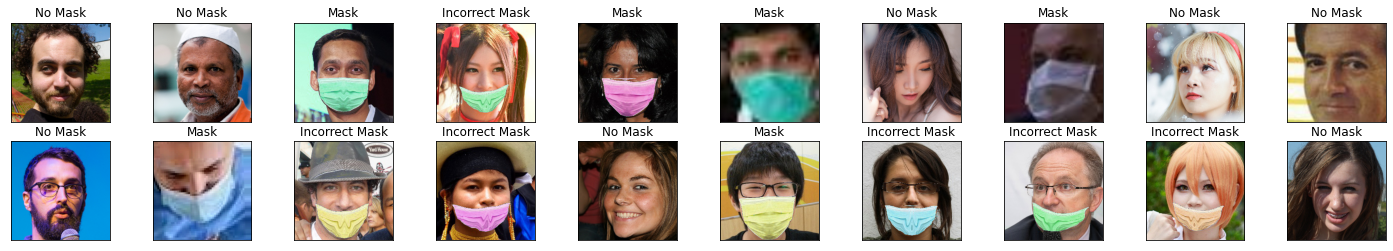

In [6]:
val_data = torch.utils.data.DataLoader(val_set, batch_size=32, num_workers=1, shuffle=True)
display_data(val_data)

#### Check Our Test Data

<ipython-input-4-5946c92dc02c>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])


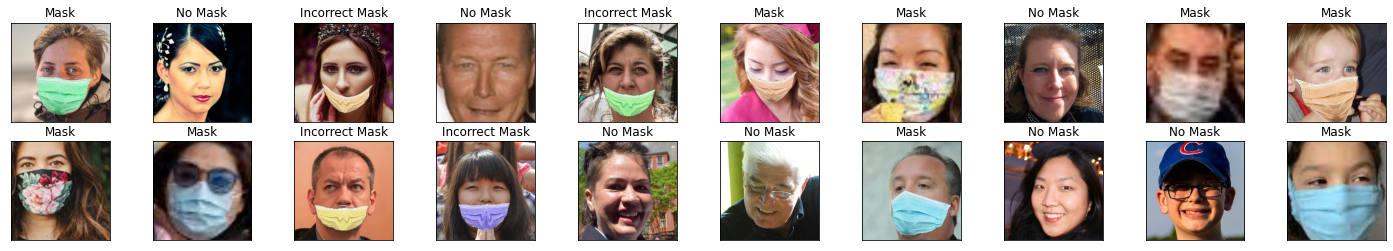

In [7]:
test_data = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=1, shuffle=True)
display_data(test_data)

## Neural Networks
All of our networks are Convolutional Neural Networks due to their advantages while working with image classification problems.
All CNNs receive at RGB 240x240 input has a final output layer of 3 neurons for mask, no mask and incorrect mask.

Note: CNN versions do not indicate their success. For example version 2 may not necessarily be better than version 1

## Basic CNN Model - Version 1
This is the basic CNN version model, that has similar parameters to the CNN known as LeNet-5 (with 2 convolutional and pooling layers, followed by a flattening convolutional layer, then two linear layers). The SGD optimizer was used for our primary model because it is commonly used in CNNs and updates parameters based on each training sample.

In [8]:
class Basic_CNN(nn.Module):
    # 7 layers: 2 conv, 2 max pool, 2 linear, 1 output
    def __init__(self):
        self.name = "Basic_CNN"
        super(Basic_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels=3, out_chanels=5, kernel_size=5
        self.pool = nn.MaxPool2d(2, 2) #kernel_size=2, stride=2 
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels=5, out_chanels=10, kernel_size=5
        self.fc1 = nn.Linear(10*57*57, 32)
        self.fc2 = nn.Linear(32, 3) #CHANGED
    def weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform(m.weight.data)
            nn.init.xavier_uniform(m.bias.data)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img))) #relu activation function
        x = self.pool(F.relu(self.conv2(x))) #relu activation function
        x = x.view(-1, 10*57*57)
        x = F.relu(self.fc1(x)) #relu activation function
        x = self.fc2(x)
        return x

## CNN Model - Version 2

Layer 1: 3x3 convolution (12 features) + pooling + ReLU

Layer 2: 3x3 convolution (24 features) + pooling + ReLU

Layer 3: Dropout p=0.2

Layer 4: Fully connected

In [15]:
class CNN_V2(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN_V2, self).__init__()
        self.name = "CNN_V2"
        
        # Our images are RGB, so we have input channels = 3. 
        #12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # 240x240 image tensors will be pooled twice with a kernel size of 2. 240/2/2 is 60.
        # Thus 60x60 tensors and 24 tensors
        self.fc = nn.Linear(in_features=60 * 60 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        
        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 
        
        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))  
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
        x = x.view(-1, 60 * 60 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        
        return x

# CNN V3

Layer 1: 10x10 convolution (64 features) with stride=4 + ReLU

Layer 2: 4 6x6 convolutions (64 features) + ReLU

Layer 3: Dropout p=0.2

Layer 4: Fully connected

In [10]:
class CNN_V3(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN_V3, self).__init__()
        self.name = "CNN_V3"
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10, stride=4, padding=3)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=6, stride=1)
        
        self.drop = nn.Dropout2d(p=0.2)
        
        # 240x240x3 ==conv1=> 60x60x64 ==4x conv2=> 40x40x64
        self.fc = nn.Linear(in_features=40*40*64, out_features=num_classes)

    def forward(self, x):
        # Convolution with large kernel + stride to prevent need for max pooling (maintains accuracy and speeds up training)
        x = F.relu(self.conv1(x)) 
        
        # 64 feature convolutional layers
        x = F.relu(self.conv2(x)) 
        x = F.relu(self.conv2(x)) 
        x = F.relu(self.conv2(x)) 
        x = F.relu(self.conv2(x)) 

        # Dropout layer
        x = F.dropout(self.drop(x), training=self.training)
        
        x = x.view(-1, 40*40*64)
        x = self.fc(x)
        
        return x

## Training Helper Functions

In [11]:
def get_accuracy(model, data_loader):
    '''
    Gets Correct/total
    
    Model: The CNN Model
    
    data_loader: torch dataloader
    '''
    
    correct = 0
    total = 0
    for imgs, labels in data_loader:


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        #############################################


        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [12]:
def train(model, train_dataset, val_dataset, batch_size=64, learning_rate=0.001, num_epochs=1):
    #Load data
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    print("Done loading data")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    print ("Starting to train...")
    # training
    epoch = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(epoch)
        
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        print("Epoch #: {0} Accuracy: {1}".format(epoch, train_acc[epoch]))
        
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
    
    best_epoch = np.argmax(val_acc)
    model_path = "models/model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, best_epoch)
    torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Best Epoch: {} (Train Acc = {}, Val Acc = {})".format(best_epoch, train_acc[best_epoch], val_acc[best_epoch]))

# Training

### CNN V1

CUDA is available!  Training on GPU ...
Done loading data
Starting to train...
Epoch #: 0 Accuracy: 0.618077474892396
Epoch #: 1 Accuracy: 0.7908177905308464
Epoch #: 2 Accuracy: 0.8370157819225251
Epoch #: 3 Accuracy: 0.860545193687231
Epoch #: 4 Accuracy: 0.8777618364418939
Epoch #: 5 Accuracy: 0.8743185078909612
Epoch #: 6 Accuracy: 0.8889526542324246
Epoch #: 7 Accuracy: 0.891535150645624
Epoch #: 8 Accuracy: 0.8984218077474893
Epoch #: 9 Accuracy: 0.9041606886657102
Epoch #: 10 Accuracy: 0.9064562410329986
Epoch #: 11 Accuracy: 0.9124820659971306
Epoch #: 12 Accuracy: 0.9015781922525108
Epoch #: 13 Accuracy: 0.9205164992826399
Epoch #: 14 Accuracy: 0.9222381635581062
Epoch #: 15 Accuracy: 0.9193687230989956
Epoch #: 16 Accuracy: 0.9116212338593974
Epoch #: 17 Accuracy: 0.9208034433285509
Epoch #: 18 Accuracy: 0.9256814921090387
Epoch #: 19 Accuracy: 0.9328550932568149
Epoch #: 20 Accuracy: 0.9159253945480631
Epoch #: 21 Accuracy: 0.9446197991391678
Epoch #: 22 Accuracy: 0.94375896

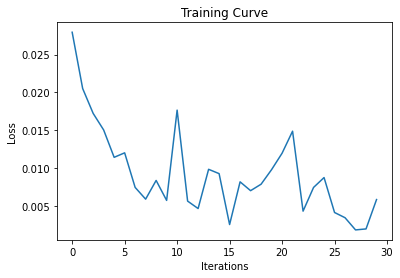

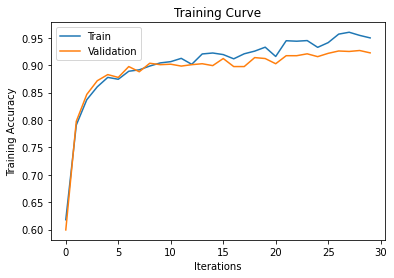

Final Training Accuracy: 0.9497847919655668
Final Validation Accuracy: 0.9224806201550387
Best Epoch: 28 (Train Acc = 0.9543758967001434, Val Acc = 0.9267872523686477)


In [13]:
use_cuda = True
torch.manual_seed(2020)
model = Basic_CNN()
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train(model, train_set, val_set, batch_size = 32, learning_rate = 0.0003, num_epochs = 30)

### CNN V2

CUDA is available!  Training on GPU ...
Done loading data
Starting to train...
Epoch #: 0 Accuracy: 0.581635581061693
Epoch #: 1 Accuracy: 0.805738880918221
Epoch #: 2 Accuracy: 0.8553802008608321
Epoch #: 3 Accuracy: 0.8599713055954089
Epoch #: 4 Accuracy: 0.8777618364418939
Epoch #: 5 Accuracy: 0.8869440459110474
Epoch #: 6 Accuracy: 0.8835007173601148
Epoch #: 7 Accuracy: 0.8921090387374462
Epoch #: 8 Accuracy: 0.8995695839311334
Epoch #: 9 Accuracy: 0.8987087517934003
Epoch #: 10 Accuracy: 0.9142037302725968
Epoch #: 11 Accuracy: 0.909325681492109
Epoch #: 12 Accuracy: 0.9104734576757533
Epoch #: 13 Accuracy: 0.9196556671449068
Epoch #: 14 Accuracy: 0.9170731707317074
Epoch #: 15 Accuracy: 0.9248206599713056
Epoch #: 16 Accuracy: 0.9164992826398852
Epoch #: 17 Accuracy: 0.927116212338594
Epoch #: 18 Accuracy: 0.9360114777618365
Epoch #: 19 Accuracy: 0.9331420373027259
Epoch #: 20 Accuracy: 0.9362984218077475
Epoch #: 21 Accuracy: 0.9374461979913917
Epoch #: 22 Accuracy: 0.940315638

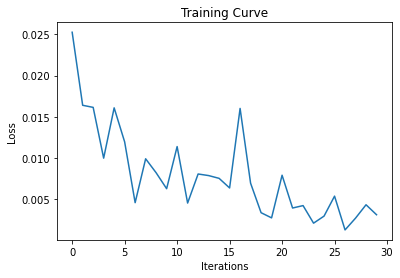

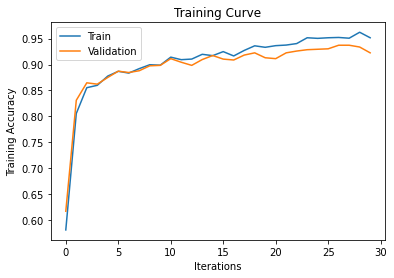

Final Training Accuracy: 0.951506456241033
Final Validation Accuracy: 0.9224806201550387
Best Epoch: 26 (Train Acc = 0.952080344332855, Val Acc = 0.9371231696813093)


In [16]:
use_cuda = True
torch.manual_seed(2020)
model = CNN_V2()
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train(model, train_set, val_set, batch_size = 32, learning_rate = 0.0003, num_epochs = 30)

### CNN V3

CUDA is available!  Training on GPU ...
Done loading data
Starting to train...
Epoch #: 0 Accuracy: 0.3489239598278336
Epoch #: 1 Accuracy: 0.5411764705882353
Epoch #: 2 Accuracy: 0.7807747489239598
Epoch #: 3 Accuracy: 0.8324246771879483
Epoch #: 4 Accuracy: 0.8619799139167862
Epoch #: 5 Accuracy: 0.8582496413199426
Epoch #: 6 Accuracy: 0.8952654232424677
Epoch #: 7 Accuracy: 0.884648493543759
Epoch #: 8 Accuracy: 0.909038737446198
Epoch #: 9 Accuracy: 0.9291248206599713
Epoch #: 10 Accuracy: 0.896987087517934
Epoch #: 11 Accuracy: 0.9466284074605452
Epoch #: 12 Accuracy: 0.9497847919655668
Epoch #: 13 Accuracy: 0.9457675753228121
Epoch #: 14 Accuracy: 0.957245337159254
Epoch #: 15 Accuracy: 0.9446197991391678
Epoch #: 16 Accuracy: 0.9503586800573888
Epoch #: 17 Accuracy: 0.9715925394548063
Epoch #: 18 Accuracy: 0.96987087517934
Epoch #: 19 Accuracy: 0.9354375896700143
Epoch #: 20 Accuracy: 0.9443328550932568
Epoch #: 21 Accuracy: 0.9704447632711621
Epoch #: 22 Accuracy: 0.96183644189

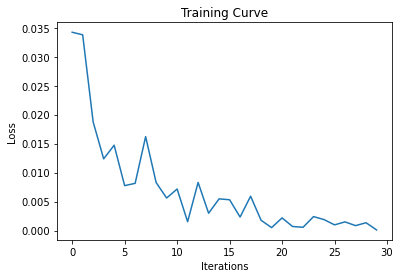

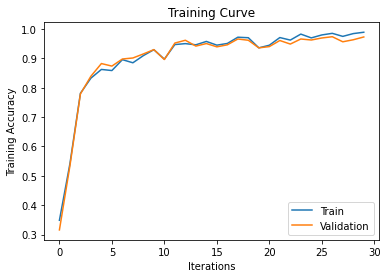

Final Training Accuracy: 0.9885222381635581
Final Validation Accuracy: 0.9724375538329026
Best Epoch: 26 (Train Acc = 0.9847919655667144, Val Acc = 0.9732988802756245)


In [17]:
use_cuda = True
torch.manual_seed(2020)
model = CNN_V3()
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train(model, train_set, val_set, batch_size = 32, learning_rate = 0.0003, num_epochs = 30)

# Testing

In [19]:
use_cuda = True
torch.manual_seed(2020)

model_1 = Basic_CNN()
model_2 = CNN_V2()
model_3 = CNN_V3()

#Test
model_1.load_state_dict(torch.load("models/CNN_1_lr=0.0003"))
model_2.load_state_dict(torch.load("models/CNN_2_lr=0.0003"))
model_3.load_state_dict(torch.load("models/CNN_3_lr=0.0003"))

if use_cuda and torch.cuda.is_available():
    model_1.cuda()
    model_2.cuda()
    model_3.cuda()
    
models = [model_1, model_2, model_3]

for model in models:
    test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)
    test_accuracy = get_accuracy(model, test_dataloader)
    print("Test accuracy for model {}: {:.4f}".format(model.name, test_accuracy))

Test accuracy for model Basic_CNN: 0.9080
Test accuracy for model CNN_V2: 0.9183
Test accuracy for model CNN_V3: 0.9630


# Conclusions

### All models

It was determined that Stochastic Gradient Descent (SGD) provided the best results for our models.

CrossEntropyLoss was also chosen as the loss function across all models, as we are dealing with a multi class classification problem. Cross entropy loss punishes predictions with low accuracy so our model can confidently distinguish how masks are being worn.

A learning rate of 0.0003 and 30 epochs provided the best results across all models.

Using ReLU as the activation function across all layers also showed positive results.

### CNN 1
We treated this as sort of a 'baseline' CNN to tweak learning rate / epoch # / loss functions / optimizer / activation functions.

### CNN 2

This model was able to perform slightly better than CNN 1, by making use of a dropout layer.

In a study by Park and Kwak (2016), it was shown that using dropout on the convolutional layers with a low probability (p=0.2) can improve results, as opposed to the method of using dropout between fully connected layers*. This approach also proved useful in our model.

*Source:  Park, S., & Kwak, N. (2016). Analysis on the Dropout Effect in Convolutional Neural Networks. ACCV.

### CNN 3

The main idea behind this model was trying a different approach by using a large kernel with a large stride instead of using pooling layers like typical CNNs.

We also expiremented with using large amounts of feature maps (64), and applying consecutive convolutions of the same size. This idea was inspired by the architecture of VGGnet.

Using just 1 convolution after the first convolution layer had poor results and strong overfitting, however adding more and more consecutive convolutions reduced the overfitting and actually improved the accuracy compared to CNN 2.

We also expiremented with the number of feature maps used in the consecutive convolutions, and found that 64 provided optimal results.